In [ ]:
# Install dependencies
%pip install ultralytics
%pip install torch
%pip install torchvision
%pip install torchaudio
%pip install opencv-python
%pip install timm
%pip install easydict

'c:\\Users\\esabh\\OneDrive\\Documents\\GitHub\\Follow-me-bot'

In [1]:
# Import necessary libraries
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import time
from deep_sort.utils.parser import get_config
from deep_sort.deep_sort import DeepSort
from deep_sort.sort.tracker import Tracker

### Human detection using YOLOv8
To keep the computation real-time friendly, the lighter *YOLOv8s* variant is used but other variants can also be used.

In [ ]:
# Load a YOLOv8 model
# YOLOv8 variants:
# Top to Down: Small size, low accuracy -> Large size, high accuracy
#     yolov8n.pt
#     yolov8s.pt
#     yolov8m.pt
#     yolov8l.pt
#     yolov8x.pt

model = YOLO("yolov8l.pt") # yolov8s.pt

# Load a test image
path = 'data/test_img.png'
img = cv2.imread(path)

# Detect person using YOLO
results = model(img)

# Display the results
detect_img = results[0].plot()
detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)

plt.imshow(detect_img)
plt.axis('off')
plt.show()

 55%|█████▌    | 72.1M/131M [00:20<01:48, 566kB/s] 

### Computing depth using MiDAS
The smallest variant i.e., *MiDaS_small* is used here but other variants can also be used. The computed depth values are inversely proportional to the actual depth and have no units. During the first run, this will download the model weights and store it in cache, hence an internet connection is required to run it.

In [7]:
# Load MiDAS model
# Different MiDAS models:
# Top to Down: Large, more accuracy -> Small, less accurate
#     "DPT_Large"
#     "DPT_Hybrid"
#     "MiDaS_small"

model_type = "MiDaS_small"
midas = torch.hub.load("intel-isl/MiDaS", model_type)

# If GPU available, map MiDAS execution to GPU else CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)

# Image transformation depending on MiDAS model type
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\esabh/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\esabh/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in C:\Users\esabh/.cache\torch\hub\intel-isl_MiDaS_master


In [8]:
# Inverse the depth values from depth map
def inverse_depth_value(depth_value, scale, constant=0):
    return 1.0 / (constant + depth_value * scale)

# Exponential moving average filter to smoothen depth values
def apply_ema_filter(current_depth, alpha):
    global previous_depth
    filtered_depth = alpha * current_depth + (1 - alpha) * previous_depth
    previous_depth = filtered_depth  # Update the previous depth value
    return filtered_depth

# Get depth map using MiDAS
def get_depth_map(img):
    input_batch = transform(img).to(device)
    # Perform depth prediction using MiDAS
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # Convert the depth map tensor to a NumPy array for plotting
    depth_map = prediction.cpu().numpy()

    return depth_map

person_height = 1800 # in mm
focal_length_sensor_height_ratio = 0.827433 # IPhone 14 Pro Max camera parameter

def distance_to_object(real_object_height_mm, image_height_px, object_height_px):
    # return focal_length_mm * real_object_height_mm * image_height_px/ (object_height_px * sensor_height_mm)
    return focal_length_sensor_height_ratio * real_object_height_mm * image_height_px/ (object_height_px)

In [9]:
def find_scale(img):
    results = model(img, verbose=False)
    # Get depth map
    depth_map = get_depth_map(img)
    # Get bounding box of all detected person
    detected_objects = results[0].boxes.xyxy

    max_area = 0

    # For now this step iterates through all bounnding boxes, later we need to only use our locked bounding box
    for obj in detected_objects:
        x1, y1, x2, y2 = obj  # Extract bounding box coordinates
        object_region_depths = depth_map[int(y1):int(y2), int(x1):int(x2)]  # Extract region from depth map
        area = (x2-x1)*(y2-y1)
        if area > max_area:
            max_area = area
            # Calculate mean depth of bounded object
            depth_value = np.mean(object_region_depths)
            depth_in_mm = distance_to_object(person_height, img.shape[0], y2-y1)

            # Find scale to convert depth value to distance
            scale = 1 / (depth_value * depth_in_mm)
    return scale

def find_scale_and_constant(img1, img2):
    midas_output = []
    true_depth = []
    for img in [img1, img2]:
        results = model(img, verbose=False)
        # Get depth map
        depth_map = get_depth_map(img)
        # Get bounding box of all detected person
        detected_objects = results[0].boxes.xyxy

        max_area = 0

        # For now this step iterates through all bounnding boxes, later we need to only use our locked bounding box
        for obj in detected_objects:
            x1, y1, x2, y2 = obj  # Extract bounding box coordinates
            object_region_depths = depth_map[int(y1):int(y2), int(x1):int(x2)]  # Extract region from depth map
            area = (x2-x1)*(y2-y1)
            if area > max_area:
                max_area = area
                # Calculate mean depth of bounded object
                depth_value = np.mean(object_region_depths)
                depth_in_mm = distance_to_object(person_height, img.shape[0], y2-y1)
        midas_output.append(depth_value)
        true_depth.append(depth_in_mm)
    scale = (1.0/true_depth[0] - 1.0/true_depth[1]) / (midas_output[0] - midas_output[1])
    constant = 1.0/true_depth[0] - scale * midas_output[0]
    return scale, constant

Text(0.5, 1.0, 'Depth Map')

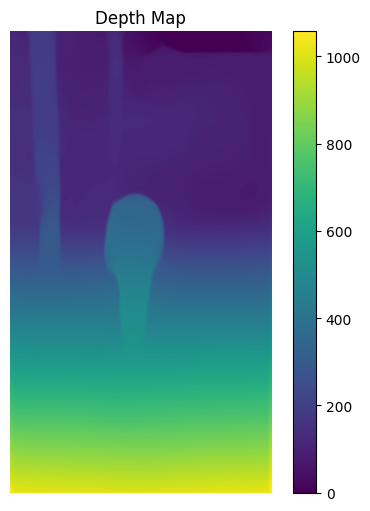

In [10]:
# Run and view results from depth map function
depth_map = get_depth_map(img)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(depth_map, cmap='viridis')
plt.colorbar()
plt.title('Depth Map')

In [ ]:
def process_frame(frame):
    og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = og_frame.copy()
    classes = [0]   # Person class
    result = model(frame, device=device, classes=classes)
    
    #depth_map = get_depth_map(frame)

    boxes = result[0].boxes  # Boxes object for bbox outputs
    probs = result[0].probs  # Class probabilities for classification outputs
    cls = boxes.cls.tolist()  # Convert tensor to list
    conf = boxes.conf
    xywh = boxes.xywh  # box with xywh format

    pred_cls = np.array(cls)
    conf = conf.detach().cpu().numpy()
    bboxes_xywh = xywh
    bboxes_xywh = xywh.cpu().numpy()
    bboxes_xywh = np.array(bboxes_xywh, dtype=float)

    tracks = tracker.update(bboxes_xywh, conf, og_frame) # setting up the tracker

    for track in tracker.tracker.tracks:
        if(track.track_id == 1):
            hits = track.hits
            # Get bounding box coordinates in (x1, y1, x2, y2) format
            x1, y1, x2, y2 = track.to_tlbr()  
            depth_in_mm = distance_to_object(person_height, frame.shape[0], y2-y1)
            # Extract bounding box region from depth map
            #object_region_depths = depth_map[int(y1):int(y2), int(x1):int(x2)]  
            # Calculate mean depth of bounded object
            # depth_value = np.mean(object_region_depths)  
            # # Inverse the depth value
            # depth_value = inverse_depth_value(depth_value, scale)
            # depth_value = (apply_ema_filter(depth_value, alpha))
            # Draw a rectangle and print depth value under the bounding box
            cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
            font = cv2.FONT_HERSHEY_SIMPLEX
            depth_text = f"{depth_in_mm:.2f}"
            cv2.putText(og_frame, depth_text, (int(x1), int(y2+25)), font, 1, (0,0,0), 2, cv2.LINE_AA)

    return og_frame

In [ ]:
# Run the algorithm for a video


# Set input and output video path
video_path = "data/test_vid2.mp4"
output_path = "data/output2.mp4"

# Load DeepSORT model
deep_sort_weights = 'deep_sort/deep/checkpoint/ckpt.t7' #load the pretrained model
tracker = DeepSort(model_path=deep_sort_weights, max_age=2000)
classes = [0]  # Person
class_name = 'person'

# Get the video properties
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
# Define the output format and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
# Initialise variables
i = 0
counter, fps, elapsed = 0, 0, 0
start_time = time.perf_counter()
# Scale for depth inversion
scale = 0.01 
alpha = 0.2
previous_depth = 0.0
while True:
    ret, frame = cap.read()
    if ret:
        # Get and display depth from frame
        og_frame = process_frame(frame)

        # Update FPS and place on frame
        current_time = time.perf_counter()
        elapsed = (current_time - start_time)
        counter += 1
        if elapsed > 1:
            fps = counter / elapsed
            counter = 0
            start_time = current_time

        # Write the frame to the output video file
        out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()


0: 384x640 1 person, 364.1ms
Speed: 3.9ms preprocess, 364.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 322.8ms
Speed: 2.0ms preprocess, 322.8ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 322.0ms
Speed: 1.3ms preprocess, 322.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 330.5ms
Speed: 2.1ms preprocess, 330.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 323.8ms
Speed: 2.4ms preprocess, 323.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 318.3ms
Speed: 2.5ms preprocess, 318.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 323.5ms
Speed: 1.4ms preprocess, 323.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 319.3ms
Speed: 1.4ms preprocess, 319.3ms inference, 1.1ms postprocess per image at